# 목차

- 준비
1. 인물모드 직접 해 보기
    - 인물 모드 사진 3장 만들기
    - 고양이 모드 사진 1장 만들기
    - 크로마키 배경을 합성해보기
2. 사진의 문제점 찾기
    - 최소 2가지 이상 문제점을 찾아서 표시하기
3. 해결 방법 제안해보기
    - 이때 단답형이 아닌 설명문으로 작성해야함..
    > - 이런 문제는 이 기술에 이런 방법을 응용하여 다음과 같이 해결해보고자 한다.

In [1]:
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
import cv2

model_file = './model/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [2]:
# 클래스화 하기
class PotoChanger:
    human_color = (128,128,192)
    def __init__(
        self,
        img_path:str,
        target:str = 'human', 
        background:str = 'blur'
        ):
        
        self.img_path = img_path 
        self.target = target
        self.background = background
        self.img_org = cv2.imread(self.img_path)

    # 원본값 출력
    def org_show(self):
        plt.imshow(cv2.cvtColor(self.img_org, cv2.COLOR_BGR2RGB))
    
    def predict(self):
        self.segvalues, self.model_output = model.segmentAsPascalvoc(self.img_path)
    
    def mapping(self):
        label = {
            'human':(128,128,192),
            'cat':(0,0,64)
        }
        self.map = np.all(self.model_output==label[self.target], axis=-1)

    def bluring(self, n:int = 25):
        self.background_img = cv2.blur(self.img_org, (n,n))

    def background_resize(self):
        src = cv2.imread(self.background)
        self.background_img = cv2.resize(src, self.img_org.shape[1::-1])

    def make_poto(self):
        img_mask = self.map.astype(np.uint8) * 255
        img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
        img_bg_mask = cv2.bitwise_not(img_mask_color)
        img_bg = cv2.bitwise_and(self.background_img, img_bg_mask)
        self.img_concat = np.where(img_mask_color==255, self.img_org, img_bg)

    def result_show(self):
        plt.imshow(cv2.cvtColor(self.img_concat, cv2.COLOR_BGR2RGB))

    def pipeline(self):
        self.predict()
        self.mapping()
        if self.background == 'blur':
            self.bluring()
        else:
            self.background_resize()
        print(self.background_img.shape)
        self.make_poto()
        self.result_show()

# 1. 인물모드 직접 해 보기

## 인물 모드 사진 3장 만들기

- 사진 가져오기

In [3]:
potoChanger = [PotoChanger(f'./img/{i}.jpg') for i in range(3)]

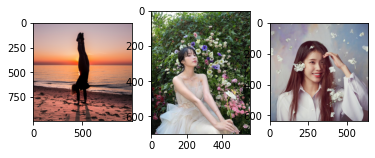

In [4]:
for i in range(3):
    plt.subplot(1,3,i+1)
    potoChanger[i].org_show()

- 사진 모델에 돌리고 결과값 보기

100%|██████████| 3/3 [00:13<00:00,  4.60s/it]


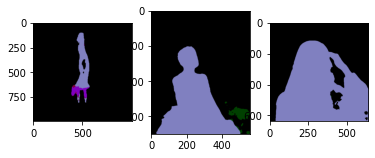

In [5]:
for i in tqdm(range(3)):
    potoChanger[i].predict()
    plt.subplot(1,3,i+1)
    plt.imshow(potoChanger[i].model_output)

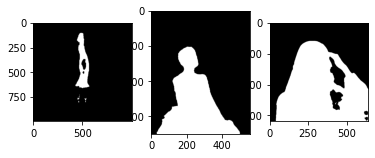

In [6]:
for i in range(3):
    plt.subplot(1,3,i+1)
    potoChanger[i].mapping()
    plt.imshow(potoChanger[i].map, cmap='gray')

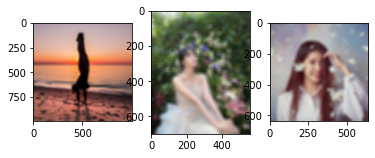

In [7]:
for i in range(3):
    plt.subplot(1,3,i+1)
    potoChanger[i].bluring()
    plt.imshow(cv2.cvtColor(potoChanger[i].background_img, cv2.COLOR_BGR2RGB))

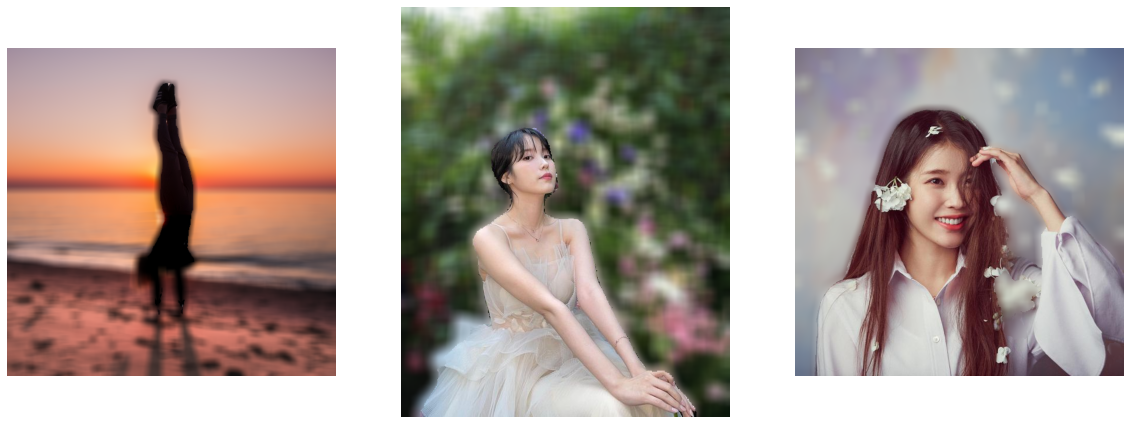

In [8]:
plt.figure(figsize=(20,20))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.axis('off')
    potoChanger[i].make_poto()
    plt.imshow(cv2.cvtColor(potoChanger[i].img_concat, cv2.COLOR_BGR2RGB))

## 고양이 시맨틱 세그멘테이션 하기

(367, 550, 3)


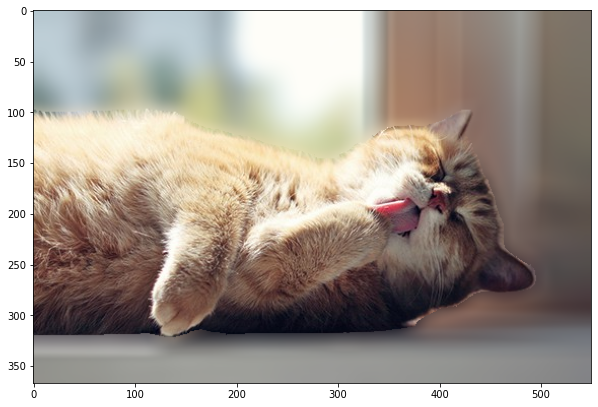

In [9]:
cat = PotoChanger('./img/4.jpg', target='cat')
cat.pipeline()
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(cat.img_concat, cv2.COLOR_BGR2RGB))

## 크로마키 적용

(640, 640, 3)


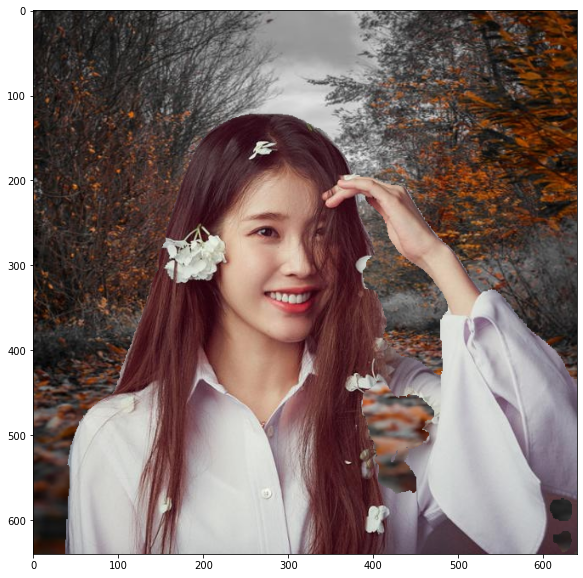

In [10]:
cat = PotoChanger('./img/2.jpg', target='human',background='./img/background.jpeg')
cat.pipeline()
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(cat.img_concat, cv2.COLOR_BGR2RGB))

# 2. 사진의 문제점 찾기

![사이사이에 구멍](./img/result_1.png)
![근경이 흐림](./img/result_2.png)